# CellViT ++ dataset preparation for fine-tuning

In [1]:
import os
import sys
from pprint import pprint

print(f"Previous exec path: {os.getcwd()}")
# move two level up
os.chdir("../../")
print(f"Current exec path: {os.getcwd()}")

Previous exec path: /workspace/source/notebooks
Current exec path: /workspace


In [2]:
# issue fix with openslide bin path

# Path to ASAP binaries
asap_bin_path = "/opt/ASAP/bin"

# Append to system PATH
os.environ["PATH"] += os.pathsep + asap_bin_path

# Verify it's in the PATH
print("ASAP Path added to PATH:", asap_bin_path)

# Add ASAP Python library path
asap_python_lib_path = "/opt/ASAP/lib/python3.8/site-packages"
sys.path.append(asap_python_lib_path)

# Verify it's in sys.path
print("ASAP Python library path added:", asap_python_lib_path)

ASAP Path added to PATH: /opt/ASAP/bin
ASAP Python library path added: /opt/ASAP/lib/python3.8/site-packages


In [3]:
from wholeslidedata import WholeSlideImage
from wholeslidedata.interoperability.openslide.backend import (
    OpenSlideWholeSlideImageBackend,
)

import numpy as np

from matplotlib import pyplot as plt

plt.rc("font", size=12)


## Creating a custom class batch iterator with Whole Slide Data to create patch point annotations

In [7]:
TEST_DATA_BASE_PATH = "./data/test"
test_wsi_path = os.path.join(TEST_DATA_BASE_PATH, "input", "A_P000002_PAS_CPG.tif")
test_wsa_path = os.path.join(
    TEST_DATA_BASE_PATH, "ground_truth", "A_P000002.xml" #point based annotations
)
roi_maks_path = os.path.join(TEST_DATA_BASE_PATH, "input", "A_P000002_mask.tif")


In [8]:
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch
from dicfg.magics import ConfigMagics

# This will allow loading yaml in an notebook cell
ConfigMagics.register_magics()


In [21]:
%%yaml config
training:
  - wsi:
      path: ./data/test/input/A_P000002_PAS_CPG.tif
    wsa:
      path: ./data/test/ground_truth/A_P000002_polygon.xml

In [22]:
user_config = {
    "wholeslidedata": {
        "default": {
            "yaml_source": config,  # also the path of the yaml associating wsa and wsi can be used (see training example code of the challenge)
            "seed": 42,  # seed for reproducibility
            "image_backend": "openslide",  # was asap
            "labels": {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2,
            },  # labels to be used for the annotations
            "batch_shape": {
                "batch_size": 1,  # number of patches in a batch
                "spacing": 0.25,  # spacing of the patches in micrometer/pixel
                "shape": [1024, 1024, 3],  # shape of the patches
                "y_shape": [
                    1000,
                    6,
                ],  # shape of the labels (max 1000 objects with 6 attributes (x1, y1, x2, y2, label, probablity))
            },
            "annotation_parser": {
                "sample_label_names": [
                    "roi"
                ],  # this is the label that will be used to sample the patches, so the other regions outside the roi will be ignored
            },
            "point_sampler_name": "RandomPointSampler",  # point sampler to be used
            "point_sampler": {
                "buffer": {"spacing": "${batch_shape.spacing}", "value": -64},
            },
            "patch_label_sampler_name": "DetectionPatchLabelSampler",
            "patch_label_sampler": {
                "max_number_objects": 1000,  # maximum number of objects in a patch
                "detection_labels": [
                    "lymphocytes",
                    "monocytes",
                ],  # labels to be used for the detection (output of the batch iterator)
            },
        }
    }
}


In [12]:
from wholeslidedata.interoperability.pytorch.iterator import (
    WholeSlidePyTorchBatchIterator,
)

In [23]:
with create_batch_iterator(
    user_config=user_config,
    mode="training",
    iterator_class=WholeSlidePyTorchBatchIterator,
) as training_batch_generator:
    x_batch, y_batch = next(training_batch_generator)

    pprint(x_batch)


array([[[[212, 217, 231, ..., 247, 250, 251],
         [219, 224, 234, ..., 245, 252, 245],
         [225, 227, 235, ..., 248, 249, 237],
         ...,
         [198, 201, 192, ..., 254, 254, 254],
         [205, 205, 198, ..., 254, 254, 254],
         [203, 201, 193, ..., 254, 254, 254]],

        [[194, 199, 213, ..., 247, 250, 249],
         [201, 207, 217, ..., 245, 252, 243],
         [208, 210, 218, ..., 248, 249, 235],
         ...,
         [167, 172, 166, ..., 254, 254, 254],
         [175, 177, 170, ..., 254, 254, 254],
         [173, 173, 165, ..., 254, 254, 254]],

        [[216, 221, 235, ..., 247, 250, 250],
         [223, 226, 236, ..., 245, 252, 244],
         [227, 229, 236, ..., 248, 249, 236],
         ...,
         [198, 202, 195, ..., 254, 254, 254],
         [201, 202, 195, ..., 254, 254, 254],
         [199, 196, 188, ..., 254, 254, 254]]]], dtype=uint16)


In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from matplotlib.colors import Colormap, ListedColormap
import numpy as np
from typing import List, Optional, Tuple, Union


# Create a colormap that maps index 0 -> red, index 1 -> green
color_map = ListedColormap(["red", "green"])

import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from matplotlib.colors import Colormap, ListedColormap
import numpy as np
from typing import List, Optional, Tuple, Union


## NOTE: custom method modified from the original wholeslidedata.visualization.plotting.plot_boxes code. Need to check if it's correct!
def plot_boxes_labels(
    boxes: List[Union[List[float], Tuple[float, float, float, float, int, float]]],
    max_width: Optional[float] = None,
    max_height: Optional[float] = None,
    axes: Optional[plt.Axes] = None,
    output_shape: Optional[Tuple[int, int]] = None,
    color_map: Optional[Colormap] = None,
    print_labels: bool = False,
    label_dict: Optional[dict] = None,
) -> None:
    """
    Plots bounding boxes with optional class labels on a matplotlib axis.

    Args:
        boxes (List[Tuple[float, float, float, float, int, float]]):
            A list of bounding box data where each box is a tuple or list in the format:
            (x1, y1, x2, y2, label_value, confidence).
            - x1, y1: Top-left corner coordinates of the box.
            - x2, y2: Bottom-right corner coordinates of the box.
            - label_value: Integer representing the class label (used for coloring).
            - confidence: Confidence score (currently unused but included for compatibility).
        max_width (Optional[float]): Optional maximum allowable width of a box.
            If None, no clamping will occur.
        max_height (Optional[float]): Optional maximum allowable height of a box.
            If None, no clamping will occur.
        axes (Optional[plt.Axes]): An optional matplotlib Axes object to draw the boxes on.
            If None, a new figure and axis will be created.
        output_shape (Optional[Tuple[int, int]]): Optional shape of the output image (height, width).
            Currently unused, but can be extended for scaling.
        color_map (Optional[Colormap]): A colormap instance for mapping class labels to colors.
            If None, the 'tab10' colormap will be used by default.
        print_labels (bool): Whether to print the class label near the top-left corner of each box.
        label_dict (Optional[dict]): A dictionary mapping class labels to human-readable names.

    Returns:
        None
    """
    if color_map is None:
        color_map = plt.cm.get_cmap("tab10")  # Default colormap

    if axes is None:
        _, ax = plt.subplots(1, 1)
    else:
        ax = axes

    for box in boxes:
        try:
            x1, y1, x2, y2, label_value, confidence = box
            label_value = int(label_value)  # Ensure label is an integer
        except (ValueError, TypeError):
            continue  # Skip invalid boxes

        # Skip invalid box coordinates
        if x2 <= x1 or y2 <= y1:
            continue

        # Clamp width and height if max dimensions are provided
        width = max(0, x2 - x1)
        height = max(0, y2 - y1)

        if max_width:
            width = min(max_width, width)
        if max_height:
            height = min(max_height, height)

        # Determine the color for the current label
        color = color_map(label_value % color_map.N)

        # Plot the bounding box
        rect = pltpatches.Rectangle(
            (x1, y1),
            width,
            height,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.set_axis_off()

        # Optional: Add label text near the top-left corner of the box
        if print_labels:
            if label_dict is not None:
                label_name = label_dict.get(label_value, f"Class {label_value}")
            else:
                label_name = f"Class {label_value}"

            # print(label_value, label_name)

            ax.text(
                x1,
                y1 - 3,
                label_name,
                color=color,
                fontsize=6,
                fontweight="bold",
                va="bottom",
                ha="left",
                # bbox=dict(facecolor='white', alpha=0.2, edgecolor='none'),
            )

    if axes is None:
        plt.show()


Patch shape: (1024, 1024, 3)
Boxes shape: (60, 6)
Image Height: 1024, Image Width: 1024


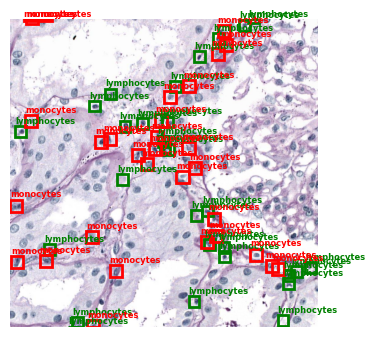

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# random number to select the patch in the batch
i = 0

patch = x_batch[i].transpose(1, 2, 0).astype("uint8")  # convert to HWC and uint8
print(f"Patch shape: {patch.shape}")

boxes = y_batch[i][~np.all(y_batch[i] == 0, axis=1)]  # remove empty rows
print(f"Boxes shape: {boxes.shape}")

# TODO: we can also filter the boxes based on the dimensions of them per patch, like in the Detectron2 iterator class

height, width = patch.shape[:2]
print(f"Image Height: {height}, Image Width: {width}")
ax.imshow(patch)
# Pass a colormap object, not a string

# TODO: fix issue with color_map, given inverted colors...

plot_boxes_labels(
    boxes,
    max_width=1024,
    max_height=1024,
    axes=ax,
    color_map=color_map,
    print_labels=True,
    label_dict={1: "lymphocytes", 2: "monocytes"},
)

plt.show()


In [30]:
import torch
import numpy as np
from wholeslidedata.iterators.batchiterator import BatchIterator


class CustomWholeSlidePyTorchPointsBatchIterator(BatchIterator):
    MIN_DETECTION_SIZE = 4  # Filter out boxes that are too small

    def __next__(self):
        # Retrieve data from the parent iterator
        x_batch, y_batch, _ = super().__next__()
        batch_data = []

        for idx, image in enumerate(x_batch):
            # Convert image from (H, W, C) to (C, H, W)
            image = image.transpose(2, 0, 1).astype("float32")

            # Extract points (center of each box) and associated classes
            points, classes = self._get_points(y_batch[idx])

            sample_dict = {
                "image": torch.as_tensor(image),  # shape: (C, H, W)
                "points": torch.as_tensor(points),  # shape: (N, 2)
                "classes": torch.as_tensor(classes),  # shape: (N,)
            }
            batch_data.append(sample_dict)

        return batch_data

    def _get_points(self, y_sample):
        """
        Given an array of bounding boxes and classes in y_sample:
        - Filters out invalid or too-small boxes.
        - Returns a list of (x_center, y_center) points (shape: (N, 2)).
        - Returns a list of classes (shape: (N,)).
        """
        # Remove rows of all zeros (invalid boxes)
        valid_boxes = y_sample[~np.all(y_sample == 0, axis=-1)]
        boxes = valid_boxes[..., :4].astype("int32")  # [xmin, ymin, xmax, ymax]
        points, classes = [], []

        for i, box in enumerate(boxes):
            # Filter small detections
            width = box[2] - box[0]
            height = box[3] - box[1]
            if width < self.MIN_DETECTION_SIZE or height < self.MIN_DETECTION_SIZE:
                continue

            # Compute the center (x, y)
            center_x = (box[0] + box[2]) / 2.0
            center_y = (box[1] + box[3]) / 2.0
            points.append([center_x, center_y])

            # Adjust class from 1-based to 0-based, if needed
            cls = valid_boxes[i][-2] - 1
            classes.append(cls)

        # Convert to numpy arrays (or leave as lists if you prefer)
        if len(points) == 0:
            points = np.zeros((0, 2), dtype=np.float32)
            classes = np.zeros((0,), dtype=np.int64)
        else:
            points = np.array(points, dtype=np.float32)
            classes = np.array(classes, dtype=np.int64)

        return points, classes


In [31]:
with create_batch_iterator(
    user_config=user_config,
    mode="training",
    iterator_class=CustomWholeSlidePyTorchPointsBatchIterator,
) as training_batch_generator:
    batch_dicts = next(training_batch_generator)

    print(len(batch_dicts))  # batch size

    print(batch_dicts[0].keys())  # keys of the first batch
    pprint(batch_dicts[0])  # print the first item of the batch


1
dict_keys(['image', 'points', 'classes'])
{'classes': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'image': tensor([[[212., 217., 231.,  ..., 247., 250., 251.],
         [219., 224., 234.,  ..., 245., 252., 245.],
         [225., 227., 235.,  ..., 248., 249., 237.],
         ...,
         [198., 201., 192.,  ..., 254., 254., 254.],
         [205., 205., 198.,  ..., 254., 254., 254.],
         [203., 201., 193.,  ..., 254., 254., 254.]],

        [[194., 199., 213.,  ..., 247., 250., 249.],
         [201., 207., 217.,  ..., 245., 252., 243.],
         [208., 210., 218.,  ..., 248., 249., 235.],
         ...,
         [167., 172., 166.,  ..., 254., 254., 254.],
         [175., 177., 170.,  ..., 254., 254., 254.],
         [173., 173., 165.,  ..., 254., 254., 254.]],

        [[216., 221., 235.,  ..., 247., 250., 250.],
         [

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Colormap, ListedColormap
from typing import Optional, Dict


def plot_patch_points(
    image,
    points,
    classes,
    axes: Optional[plt.Axes] = None,
    color_map: Optional[Colormap] = None,
    label_dict: Optional[Dict[int, str]] = None,
    print_labels: bool = False,
) -> None:
    """
    Plots a patch (image) in the background and overlays points color-coded by their class.

    Args:
        image (torch.Tensor or np.ndarray):
            A (C, H, W) array. Typically float32 or uint8 from your batch iterator.
        points (torch.Tensor or np.ndarray):
            A (N, 2) array of point coordinates: [x, y].
        classes (torch.Tensor or np.ndarray):
            A (N,) array of integer class IDs for each point.
        axes (Optional[plt.Axes]):
            Existing matplotlib Axes to draw on. If None, a new figure/axes is created.
        color_map (Optional[Colormap]):
            A colormap instance for mapping class IDs to colors. If None, uses "tab10".
        label_dict (Optional[Dict[int, str]]):
            Maps class IDs to a string label. If None, uses "Class {id}".
        print_labels (bool):
            If True, text labels are printed near each point.

    Returns:
        None
    """

    # Convert PyTorch tensors to numpy if necessary
    if hasattr(image, "cpu"):
        image = image.cpu().detach().numpy()
    if hasattr(points, "cpu"):
        points = points.cpu().detach().numpy()
    if hasattr(classes, "cpu"):
        classes = classes.cpu().detach().numpy()

    # Create a default colormap if none provided
    if color_map is None:
        color_map = plt.cm.get_cmap("tab10")

    # Create a figure/axes if none is provided
    if axes is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    else:
        ax = axes

    # image is (C, H, W) --> (H, W, C)
    image_for_plot = image.transpose(1, 2, 0)
    # If float and in the 0..255 range, cast to uint8 for better display
    if image_for_plot.dtype == np.float32 or image_for_plot.dtype == np.float64:
        # You can decide to scale if your range is 0..1, or cast directly if 0..255
        image_for_plot = image_for_plot.astype(np.uint8)

    ax.imshow(image_for_plot)
    ax.set_axis_off()

    # Scatter points
    for i, (x, y) in enumerate(points):
        class_id = int(classes[i])
        color = color_map(class_id % color_map.N)

        ax.scatter(x, y, color=color, s=20, marker="o")

        # Optionally print text labels near each point
        if print_labels:
            if label_dict and class_id in label_dict:
                text_label = label_dict[class_id]
            else:
                text_label = f"Class {class_id}"
            ax.text(
                x,
                y - 3,
                text_label,
                color=color,
                fontsize=7,
                fontweight="bold",
                va="bottom",
                ha="left",
            )

    # If we created the figure ourselves, show it
    if axes is None:
        plt.tight_layout()
        plt.show()


1
dict_keys(['image', 'points', 'classes'])


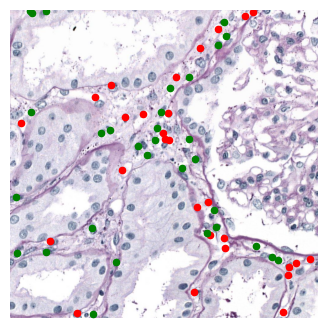

In [38]:
with create_batch_iterator(
    user_config=user_config,
    mode="training",
    iterator_class=CustomWholeSlidePyTorchPointsBatchIterator,
) as training_batch_generator:
    batch_dicts = next(training_batch_generator)
    print(len(batch_dicts))  # e.g., 1
    print(batch_dicts[0].keys())  # -> dict_keys(['image', 'points', 'classes'])

    first_sample = batch_dicts[0]
    # first_sample["image"]  -> shape: (C, H, W)
    # first_sample["points"] -> shape: (N, 2)
    # first_sample["classes"]-> shape: (N,)

# Now, let's plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plot_patch_points(
    image=first_sample["image"],
    points=first_sample["points"],
    classes=first_sample["classes"],
    axes=ax,
    color_map=ListedColormap(["red", "green"]),  # two-class example
    label_dict={0: "lymphocytes", 1: "monocytes"},
    print_labels=False,  # set True if you want text labels
)
plt.show()


In [39]:
user_config = {
    "wholeslidedata": {
        "default": {
            "yaml_source": config,  # also the path of the yaml associating wsa and wsi can be used (see training example code of the challenge)
            "seed": 42,  # seed for reproducibility
            "image_backend": "openslide",  # was asap
            "labels": {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2,
            },  # labels to be used for the annotations
            "batch_shape": {
                "batch_size": 4,  # number of patches in a batch
                "spacing": 0.25,  # spacing of the patches in micrometer/pixel
                "shape": [1024, 1024, 3],  # shape of the patches
                "y_shape": [
                    1000,
                    6,
                ],  # shape of the labels (max 1000 objects with 6 attributes (x1, y1, x2, y2, label, probablity))
            },
            "annotation_parser": {
                "sample_label_names": [
                    "roi"
                ],  # this is the label that will be used to sample the patches, so the other regions outside the roi will be ignored
            },
            "point_sampler_name": "RandomPointSampler",  # point sampler to be used
            "point_sampler": {
                "buffer": {"spacing": "${batch_shape.spacing}", "value": -64},
            },
            "patch_label_sampler_name": "DetectionPatchLabelSampler",
            "patch_label_sampler": {
                "max_number_objects": 1000,  # maximum number of objects in a patch
                "detection_labels": [
                    "lymphocytes",
                    "monocytes",
                ],  # labels to be used for the detection (output of the batch iterator)
            },
        }
    }
}


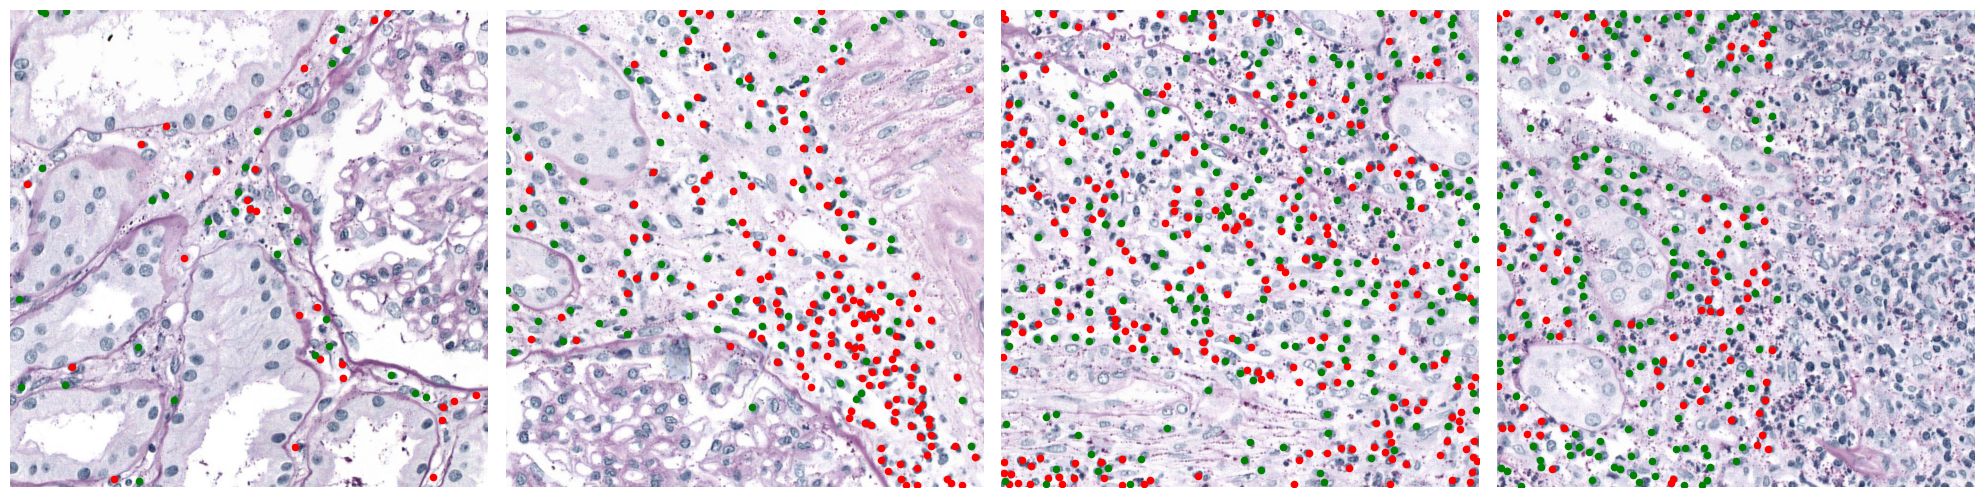

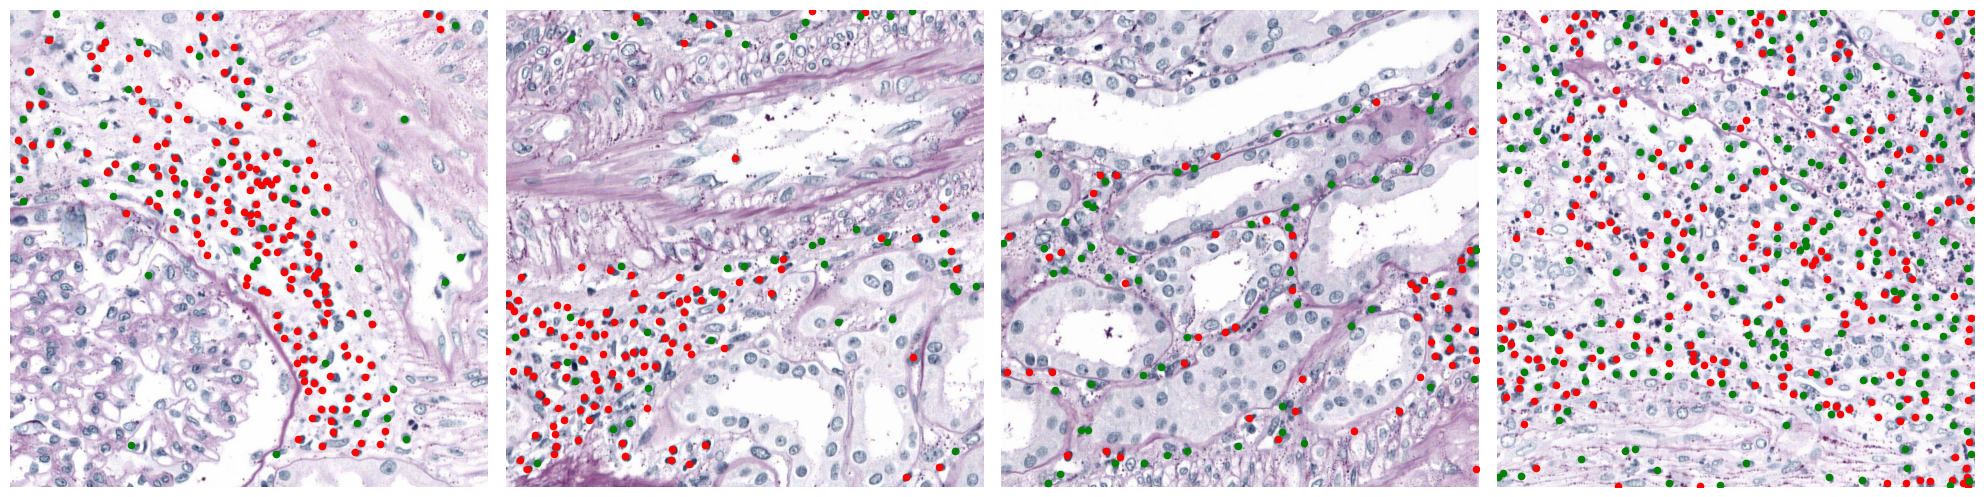

In [40]:
batch_size = 4  # must match the batch size in user_config
num_batches = 2  # number of batches to visualize

with create_batch_iterator(
    user_config=user_config,
    mode="training",
    iterator_class=CustomWholeSlidePyTorchPointsBatchIterator,
    # ^ or your updated points-based batch iterator
) as training_batch_generator:
    for _ in range(num_batches):
        batch_dicts = next(training_batch_generator)
        fig, ax = plt.subplots(1, batch_size, figsize=(20, 10))

        for i in range(batch_size):
            # 1) Convert the (C, H, W) PyTorch tensor to (H, W, C) NumPy
            patch = batch_dicts[i]["image"].cpu().detach().numpy()

            # 2) Extract points & classes (already Numpy or Torch Tensors)
            points = batch_dicts[i]["points"].cpu().detach().numpy()
            classes = batch_dicts[i]["classes"].cpu().detach().numpy()

            # 3) Use the new plot_points_labels function
            plot_patch_points(
                image=patch,
                points=points,
                classes=classes,
                axes=ax[i],  # draw on a subplot
                color_map=color_map,  # e.g., ListedColormap(["red", "green"])
                label_dict={0: "lymphocytes", 1: "monocytes"},
                print_labels=False,
            )

        plt.tight_layout()
        plt.show()


## Saving the patchified wsi patches and annotations

In [49]:
user_config = {
    "wholeslidedata": {
        "default": {
            "yaml_source": config,  # also the path of the yaml associating wsa and wsi can be used (see training example code of the challenge)
            "seed": 42,  # seed for reproducibility
            "image_backend": "openslide",  # was asap
            "labels": {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2,
            },  # labels to be used for the annotations
            "batch_shape": {
                "batch_size": 1,  # number of patches in a batch
                "spacing": 0.24199951445730394,  # spacing of the patches in micrometer/pixel
                "shape": [256, 256, 3],  # shape of the patches
                "y_shape": [
                    1000,
                    6,
                ],  # shape of the labels (max 1000 objects with 6 attributes (x1, y1, x2, y2, label, probablity))
            },
            "annotation_parser": {
                "sample_label_names": [
                    "roi"
                ],  # this is the label that will be used to sample the patches, so the other regions outside the roi will be ignored
            },
            "point_sampler_name": "RandomPointSampler",  # point sampler to be used
            "point_sampler": {
                "buffer": {"spacing": "${batch_shape.spacing}", "value": -64},
            },
            "patch_label_sampler_name": "DetectionPatchLabelSampler",
            "patch_label_sampler": {
                "max_number_objects": 1000,  # maximum number of objects in a patch
                "detection_labels": [
                    "lymphocytes",
                    "monocytes",
                ],  # labels to be used for the detection (output of the batch iterator)
            },
        }
    }
}


In [50]:
import xml.etree.ElementTree as ET


def parse_asap_dot_annotations(xml_path, group_to_label=None, ignore_groups=None):
    """
    Parse ASAP XML annotations that use Type="Dot", ignoring certain groups (e.g. "ROI").
    Returns a list of (x, y, label_id) in GLOBAL coordinates.

    Args:
        xml_path (str): Path to the ASAP XML file.
        group_to_label (dict): Maps PartOfGroup strings (e.g. "lymphocytes") to integer label IDs.
                               If None, all recognized groups default to label 0.
        ignore_groups (set): A set of group names to ignore (e.g., {"ROI"}).
                             If an annotation's PartOfGroup is in this set, it is skipped.

    Returns:
        List[Tuple[float, float, int]]
    """
    if group_to_label is None:
        group_to_label = {}

    if ignore_groups is None:
        ignore_groups = set()

    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations_root = root.find("Annotations")
    if annotations_root is None:
        raise ValueError("XML does not contain <Annotations> section")

    dots = []
    for annotation in annotations_root.findall("Annotation"):
        # e.g. <Annotation Name="..." Type="Dot" PartOfGroup="lymphocytes" ...>
        anno_type = annotation.get("Type", "")
        group_name = annotation.get("PartOfGroup", "unknown")

        # Skip if it's not a Dot annotation, or it's in the ignore list
        if anno_type.lower() != "dot":
            continue
        if group_name in ignore_groups:
            continue

        # Map group_name -> label_id
        label_id = group_to_label.get(group_name, 0)

        coords_root = annotation.find("Coordinates")
        if coords_root is None:
            continue

        for coordinate in coords_root.findall("Coordinate"):
            x_str = coordinate.get("X")
            y_str = coordinate.get("Y")
            if x_str is None or y_str is None:
                continue

            x_val = float(x_str)
            y_val = float(y_str)
            # Store global WSI coords + label
            dots.append((x_val, y_val, label_id))

    return dots


In [56]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

from wholeslidedata.iterators import create_patch_iterator


def save_patches_ignore_roi(
    xml_path,
    image_path,
    mask_path,
    patch_configuration,
    patient_id,
    group_to_label=None,
    ignore_groups=None,
    output_images_dir="./images",
    output_labels_dir="./labels",
    cpus=4,
    backend="asap",
):
    """
    1) Parses an ASAP XML file for Dot annotations, ignoring e.g. ROI groups.
    2) Iterates patches with create_patch_iterator.
    3) For each patch:
       - Convert from global WSI coords to local pixel coords.
       - Keep only those annotations inside the patch region.
       - Save the patch as <patient_id>_<idx>.png in output_images_dir
       - Save a CSV <patient_id>_<idx>.csv in output_labels_dir with columns: x,y,label_id

    Args:
        xml_path (str): Path to ASAP XML (contains Dot annotations).
        image_path (str): Path to the WSI image.
        mask_path (str): Path to the ROI mask or None.
        patch_configuration (dict): Config for create_patch_iterator (patch_size, etc.).
        patient_id (str): Will be used in saved filenames.
        group_to_label (dict): Map from PartOfGroup to integer label IDs (e.g., {"lymphocytes": 0}).
        ignore_groups (set): e.g. {"ROI"} to skip those annotations.
        output_images_dir (str): Where to save PNG patch images.
        output_labels_dir (str): Where to save CSV annotation files.
        cpus (int): Number of CPUs for patch generation.
        backend (str): "asap", "openslide", etc.
    """
    # 1) Parse XML
    annotations = parse_asap_dot_annotations(
        xml_path=xml_path, group_to_label=group_to_label, ignore_groups=ignore_groups
    )
    # annotations: list of (x_global, y_global, label_id)
    print(f"Total Dot Annotations (non-ROI): {len(annotations)}")
    pprint(annotations[:10])

    # 2) Create patch iterator
    patch_iterator = create_patch_iterator(
        image_path=image_path,
        mask_path=mask_path,
        patch_configuration=patch_configuration,
        cpus=cpus,
        backend=backend,
    )
    print(f"Number of patches: {len(patch_iterator)}")

    # Create output dirs if not exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    # 3) Iterate patches
    for idx, (patch, mask, info) in enumerate(patch_iterator):
        # e.g. patch.shape = (1, 1, H, W, 3)
        H, W, _ = info["tile_shape"]  # or from patch.squeeze().shape
        patch_x = info["x"]  # top-left global x
        patch_y = info["y"]  # top-left global y
        spacing = info["spacings"][0]  # e.g. 0.5
        
        
        
        # Calculate scaling factor (annotations are at 0.25 mpp)
        scale_factor = 0.24199951445730394 / spacing
        
        print(
            f"Patch {idx}: patch_x={patch_x}, patch_y={patch_y}, H={H}, W={W}, spacing={spacing}, scale_factor={scale_factor}"
        )

        # Convert patch to  (H, W, 3) and uint8
        patch_np = patch.squeeze().astype(np.uint8)  # shape: (H, W, 3)

        # Save patch PNG:  e.g. "patientID_0.png"
        png_filename = os.path.join(output_images_dir, f"{patient_id}_{idx}.png")
        plt.imsave(png_filename, patch_np)

        # Find local coords for any annotation inside this patch
        patch_anns = []
        for x_g, y_g, label_id in annotations:
            x_local = (x_g - patch_x) * scale_factor
            y_local = (y_g - patch_y) * scale_factor

            # Check if inside the patch
            if 0 <= x_local < W and 0 <= y_local < H:
                patch_anns.append((x_local, y_local, label_id))

        # Write CSV: "patientID_0.csv"
        csv_filename = os.path.join(output_labels_dir, f"{patient_id}_{idx}.csv")
        with open(csv_filename, mode="w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["x", "y", "label_id"])
            for xl, yl, lid in patch_anns:
                writer.writerow([xl, yl, lid])

        print(
            f"[{idx}/{len(patch_iterator)}] Saved patch -> {png_filename}, "
            f"# local points -> {len(patch_anns)}"
        )

    print("Done! All patches and CSVs saved.")


In [57]:
TEST_DATA_BASE_PATH = "./data/test"
test_wsi_path = os.path.join(TEST_DATA_BASE_PATH, "input", "A_P000002_PAS_CPG.tif")
test_wsa_path = os.path.join(
    TEST_DATA_BASE_PATH,
    "ground_truth",
    "A_P000002.xml",  # point based annotations
)
roi_maks_path = os.path.join(TEST_DATA_BASE_PATH, "input", "A_P000002_mask.tif")


In [74]:
from wholeslidedata.iterators import create_patch_iterator, PatchConfiguration

xml_path = test_wsa_path
wsi_path = test_wsi_path
mask_path = roi_maks_path  # or None if not needed


patch_configuration = PatchConfiguration(
    patch_shape=(1024, 1024, 3),
    spacings=(0.24199951445730394,),
    overlap=(0, 0),
    offset=(0, 0),
    center=False,
)

save_patches_ignore_roi(
    xml_path=xml_path,
    image_path=wsi_path,
    mask_path=mask_path,
    patch_configuration=patch_configuration,
    patient_id="A_P000002",
    group_to_label={"monocytes": 0, "lymphocytes": 1},
    ignore_groups={"ROI"},
    output_images_dir="./images",
    output_labels_dir="./labels",
    cpus=4,
    backend="asap",
)


Total Dot Annotations (non-ROI): 3818
[(60368.9219, 31877.9746, 1),
 (61360.9219, 31907.9746, 1),
 (61400.9219, 31927.9746, 1),
 (61242.9219, 31991.9746, 1),
 (61424.9219, 32017.9746, 1),
 (61408.9219, 32057.9746, 1),
 (61366.9219, 32079.9746, 1),
 (61284.9219, 32135.9746, 1),
 (61320.9219, 32153.9746, 1),
 (60328.9219, 32677.9746, 1)]
Number of patches: 42
Patch 0: patch_x=59392, patch_y=30720, H=1024, W=1024, spacing=0.24199951445730394, scale_factor=1.0
[0/42] Saved patch -> ./images/A_P000002_0.png, # local points -> 0
Patch 1: patch_x=60416, patch_y=30720, H=1024, W=1024, spacing=0.24199951445730394, scale_factor=1.0
[1/42] Saved patch -> ./images/A_P000002_1.png, # local points -> 15
Patch 2: patch_x=61440, patch_y=30720, H=1024, W=1024, spacing=0.24199951445730394, scale_factor=1.0
[2/42] Saved patch -> ./images/A_P000002_2.png, # local points -> 24
Patch 3: patch_x=58368, patch_y=31744, H=1024, W=1024, spacing=0.24199951445730394, scale_factor=1.0
[3/42] Saved patch -> ./images

In [60]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_patch_with_annotations(
    png_path: str,
    csv_path: str,
    label_colors: dict = None,
    label_dict: dict = None,
    ax: plt.Axes = None,
):
    """
    Loads a PNG patch and its CSV annotation, then plots them together.

    Args:
        png_path (str): Path to the patch image (e.g. "patientABC_0.png").
        csv_path (str): Path to the CSV annotation file (e.g. "patientABC_0.csv").
                        Must have a header [x, y, label_id] in local pixel coords.
        label_colors (dict): Maps integer label_id -> color string (e.g. {0: 'red', 1: 'blue'}).
                             If None, a default colormap is used based on label_id modulo 10.
        label_dict (dict): Optional mapping of label_id -> human-readable name
                           (e.g. {0: "lymphocytes"}). Used for text labels.
        ax (plt.Axes): Optional. If provided, the patch and points are plotted on it.
                       If None, a new figure/axes is created.

    Returns:
        None (displays the patch with overlaid points)
    """
    # 1. Load the image
    patch_img = plt.imread(png_path)  # shape: (H, W, 3)

    # 2. Read the CSV annotations
    xs, ys, labels = [], [], []
    if os.path.exists(csv_path):
        with open(csv_path, mode="r", newline="") as f:
            reader = csv.DictReader(f)
            for row in reader:
                # Convert from string to float/int
                xs.append(float(row["x"]))
                ys.append(float(row["y"]))
                labels.append(int(row["label_id"]))

    # 3. Create an axis if none was provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # 4. Display the patch
    ax.imshow(patch_img)
    ax.set_title(os.path.basename(png_path))
    ax.set_axis_off()

    # 5. Overlay points with color-coded classes
    if label_colors is None:
        # fallback to a default colormap
        colormap = plt.cm.get_cmap("tab10")
        # we'll color each point as colormap(label_id % 10)
        get_color = lambda lid: colormap(lid % 10)
    else:
        # use the user-provided dictionary
        get_color = lambda lid: label_colors.get(lid, "magenta")

    for x, y, lid in zip(xs, ys, labels):
        color = get_color(lid)
        ax.scatter(x, y, color=color, s=20, marker="o")
        # Optionally place a small text label
        if label_dict is not None:
            class_name = label_dict.get(lid, f"Class {lid}")
            ax.text(
                x,
                y - 3,
                class_name,
                color=color,
                fontsize=6,
                fontweight="bold",
                va="bottom",
                ha="left",
            )


def visualize_patches_with_annotations(
    image_dir: str,
    label_dir: str,
    patient_id: str,
    patch_indices: list,
    label_colors: dict = None,
    label_dict: dict = None,
    figsize: tuple = (16, 6),
):
    """
    Plots multiple patches side-by-side. For each patch index i:
      - loads <image_dir>/<patient_id>_<i>.png
      - loads <label_dir>/<patient_id>_<i>.csv
      - overlays annotations with label-based colors.

    Args:
        image_dir (str): Path to the folder holding the saved PNG patches.
        label_dir (str): Path to the folder holding the CSV annotation files.
        patient_id (str): e.g. "patientABC".
        patch_indices (list): Which patch IDs to plot (e.g. [0,1,2]).
        label_colors (dict): label_id -> color string.
        label_dict (dict): label_id -> class name string.
        figsize (tuple): Figure size for the row of subplots.

    Returns:
        None (displays a matplotlib figure)
    """
    n = len(patch_indices)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    if n == 1:
        axes = [axes]  # make it iterable

    for ax, idx in zip(axes, patch_indices):
        png_name = f"{patient_id}_{idx}.png"
        csv_name = f"{patient_id}_{idx}.csv"

        png_path = os.path.join(image_dir, png_name)
        csv_path = os.path.join(label_dir, csv_name)

        if not os.path.exists(png_path):
            print(f"WARNING: {png_path} does not exist.")
            continue
        if not os.path.exists(csv_path):
            print(f"WARNING: {csv_path} does not exist.")
            continue

        plot_patch_with_annotations(
            png_path, csv_path, label_colors=label_colors, label_dict=label_dict, ax=ax
        )

    plt.tight_layout()
    plt.show()


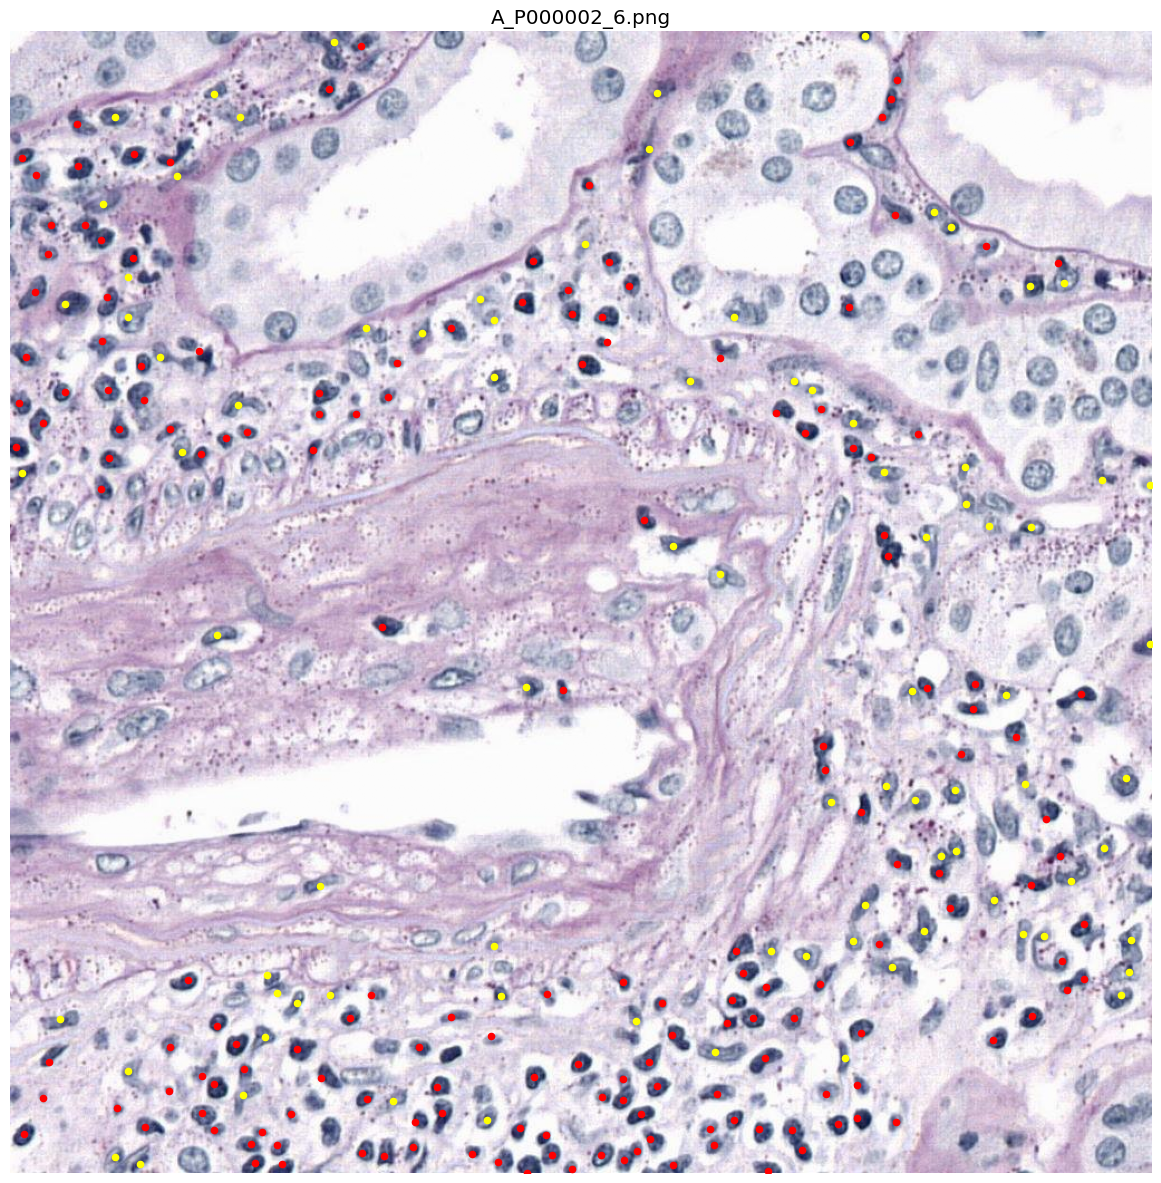

In [81]:
# Suppose you saved patches in ./images and CSVs in ./labels
# with filenames like "patientABC_0.png", "patientABC_0.csv", ...
# Suppose label 0=red, 1=blue, 2=green, etc.

label_colors = {0: "yellow", 1: "red"}
label_dict = {0: "Monocyte", 1: "Lymphocyte"}

# Plot patches #0, #1 side-by-side:
visualize_patches_with_annotations(
    image_dir="./images",
    label_dir="./labels",
    patient_id="A_P000002",
    patch_indices=[6],
    label_colors=label_colors,
    label_dict=None,
    figsize=(12, 12),
)
